In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import swiss_roll_dataset_generator as roll_gen
import dataset_generator
from importlib import reload

In [3]:
reload(mcu)

figure_num = 200
figure_point_cnt = 1600
deterministic_param_scatter = False
noise_level=0.1
lw = [1, 1]
up = [10, 10]

np.random.seed(79707)
control_vars = dataset_generator.get_control_vars(deterministic=deterministic_param_scatter, dimensionality=roll_gen.get_p(),
                                                  size=figure_num,
                                                  lw=lw, up=up)
rolls = roll_gen.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)

k = 5
c = 1e5
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, rolls, k)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c, False, 25e-5)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 25 05:06:46 PM: Your problem has 40000 variables, 1060 constraints, and 0 parameters.
(CVXPY) Jan 25 05:06:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 25 05:06:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 25 05:06:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 25 05:06:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 25 05:06:47 PM: Compiling problem (target solver=SCS).

Median rre between embedding and reconstruction: 0.06364840584229217


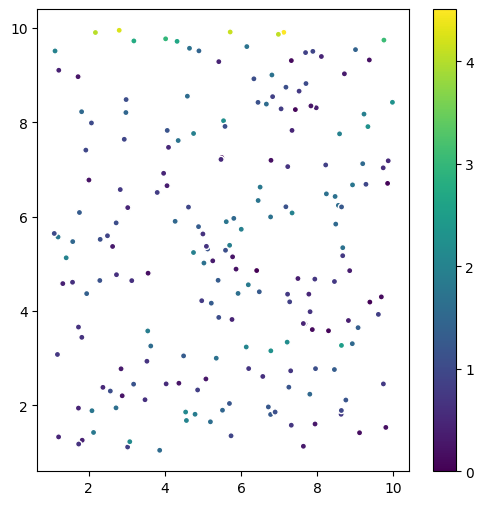

Median rre between parameters: 0.13282117901029183


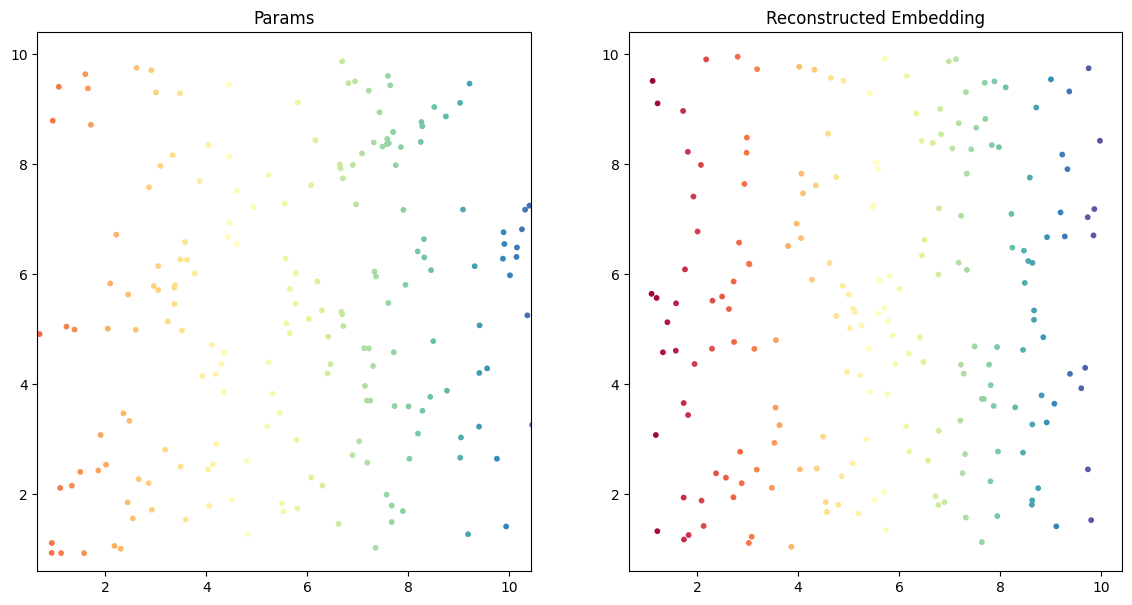

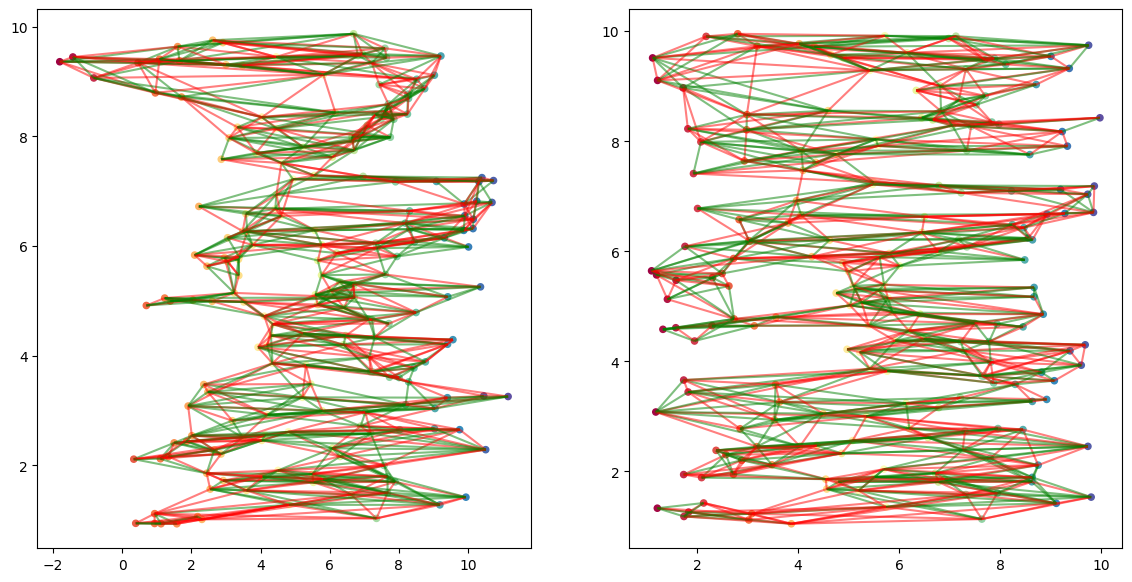

In [4]:
ld_embedding = mcu.reduce_dimensions(q, 2)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)
print("Median rre between embedding and reconstruction: {}".format(np.median(mcu.compute_rre(ld_embedding, reconstructed_y))))

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means
reconstructed_y_to_params = standardized_x * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_rre_heatmap(np.linalg.norm(ld_embedding_to_params - reconstructed_y_to_params, axis=1),
                     reconstructed_y_to_params)
print("Median rre between parameters: {}".format(np.median(rre)))
mcu.plot_embeddings_vs_parameters(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_graph(edges, ld_embedding_to_params, reconstructed_y_to_params)

Median of errors = 1.0619483952427005


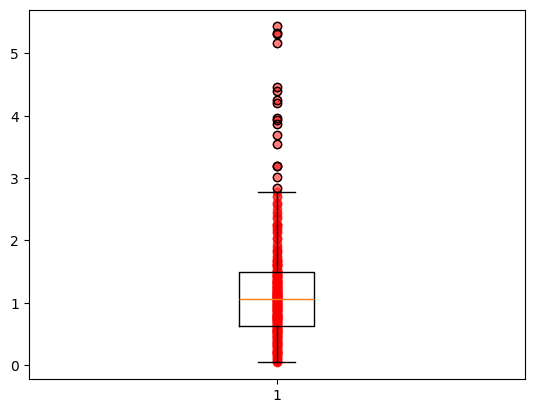

In [5]:
test_data_size = 300
test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=roll_gen.get_p(),
                                                               size=test_data_size, lw=[1, 1], up=[10, 10])
test_rolls = roll_gen.generate_array_of_swiss_rolls(test_control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)

x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler, k)
    x_opt = x_opt * x_stds + x_means
    x_opts.append(x_opt)

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(f"Median of errors = {np.median(errors)}")

In [6]:
pieces_cnt = 12
test_data_size = 50
intervals = [np.linspace(lw[0], up[0], pieces_cnt + 1), np.linspace(lw[1], up[1], pieces_cnt + 1)]
interval_runs = np.empty(shape=(pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i], intervals[1][j]]
        interval_up = [intervals[0][i + 1], intervals[1][j + 1]]
        test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=roll_gen.get_p(),
                                                               size=test_data_size, lw=interval_lw, up=interval_up)
        test_rolls = roll_gen.generate_array_of_swiss_rolls(test_control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means,
                                                       y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common),
                                np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [2.41829965 1.99328916], x_err = 12145.634718598623
x_real = [1.72552488 1.44084064]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 6837.36965857451
x_real = [1.39344711 1.59190551]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 4426.292461561496
x_real = [1.3181244  1.65212248]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 4353.646859716996
x_real = [1.06031402 1.65372913]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 10771.938009590698
x_real = [1.61380262 1.0704136 ]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 6994.0806922296515
x_real = [1.5804712  1.58237894]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 4067.5356038720147
x_real = [1.4218732 1.7003019]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 4257.8540670089205
x_real = [1.68442986 1.67579907]
-----------
x_opt  = [2.41829965 1.99328916], x_err = 10530.043042692509
x_real = [1.04193366 1.11922121]
-----------
x_opt  = [2.41829965 1.99328916], x_err 

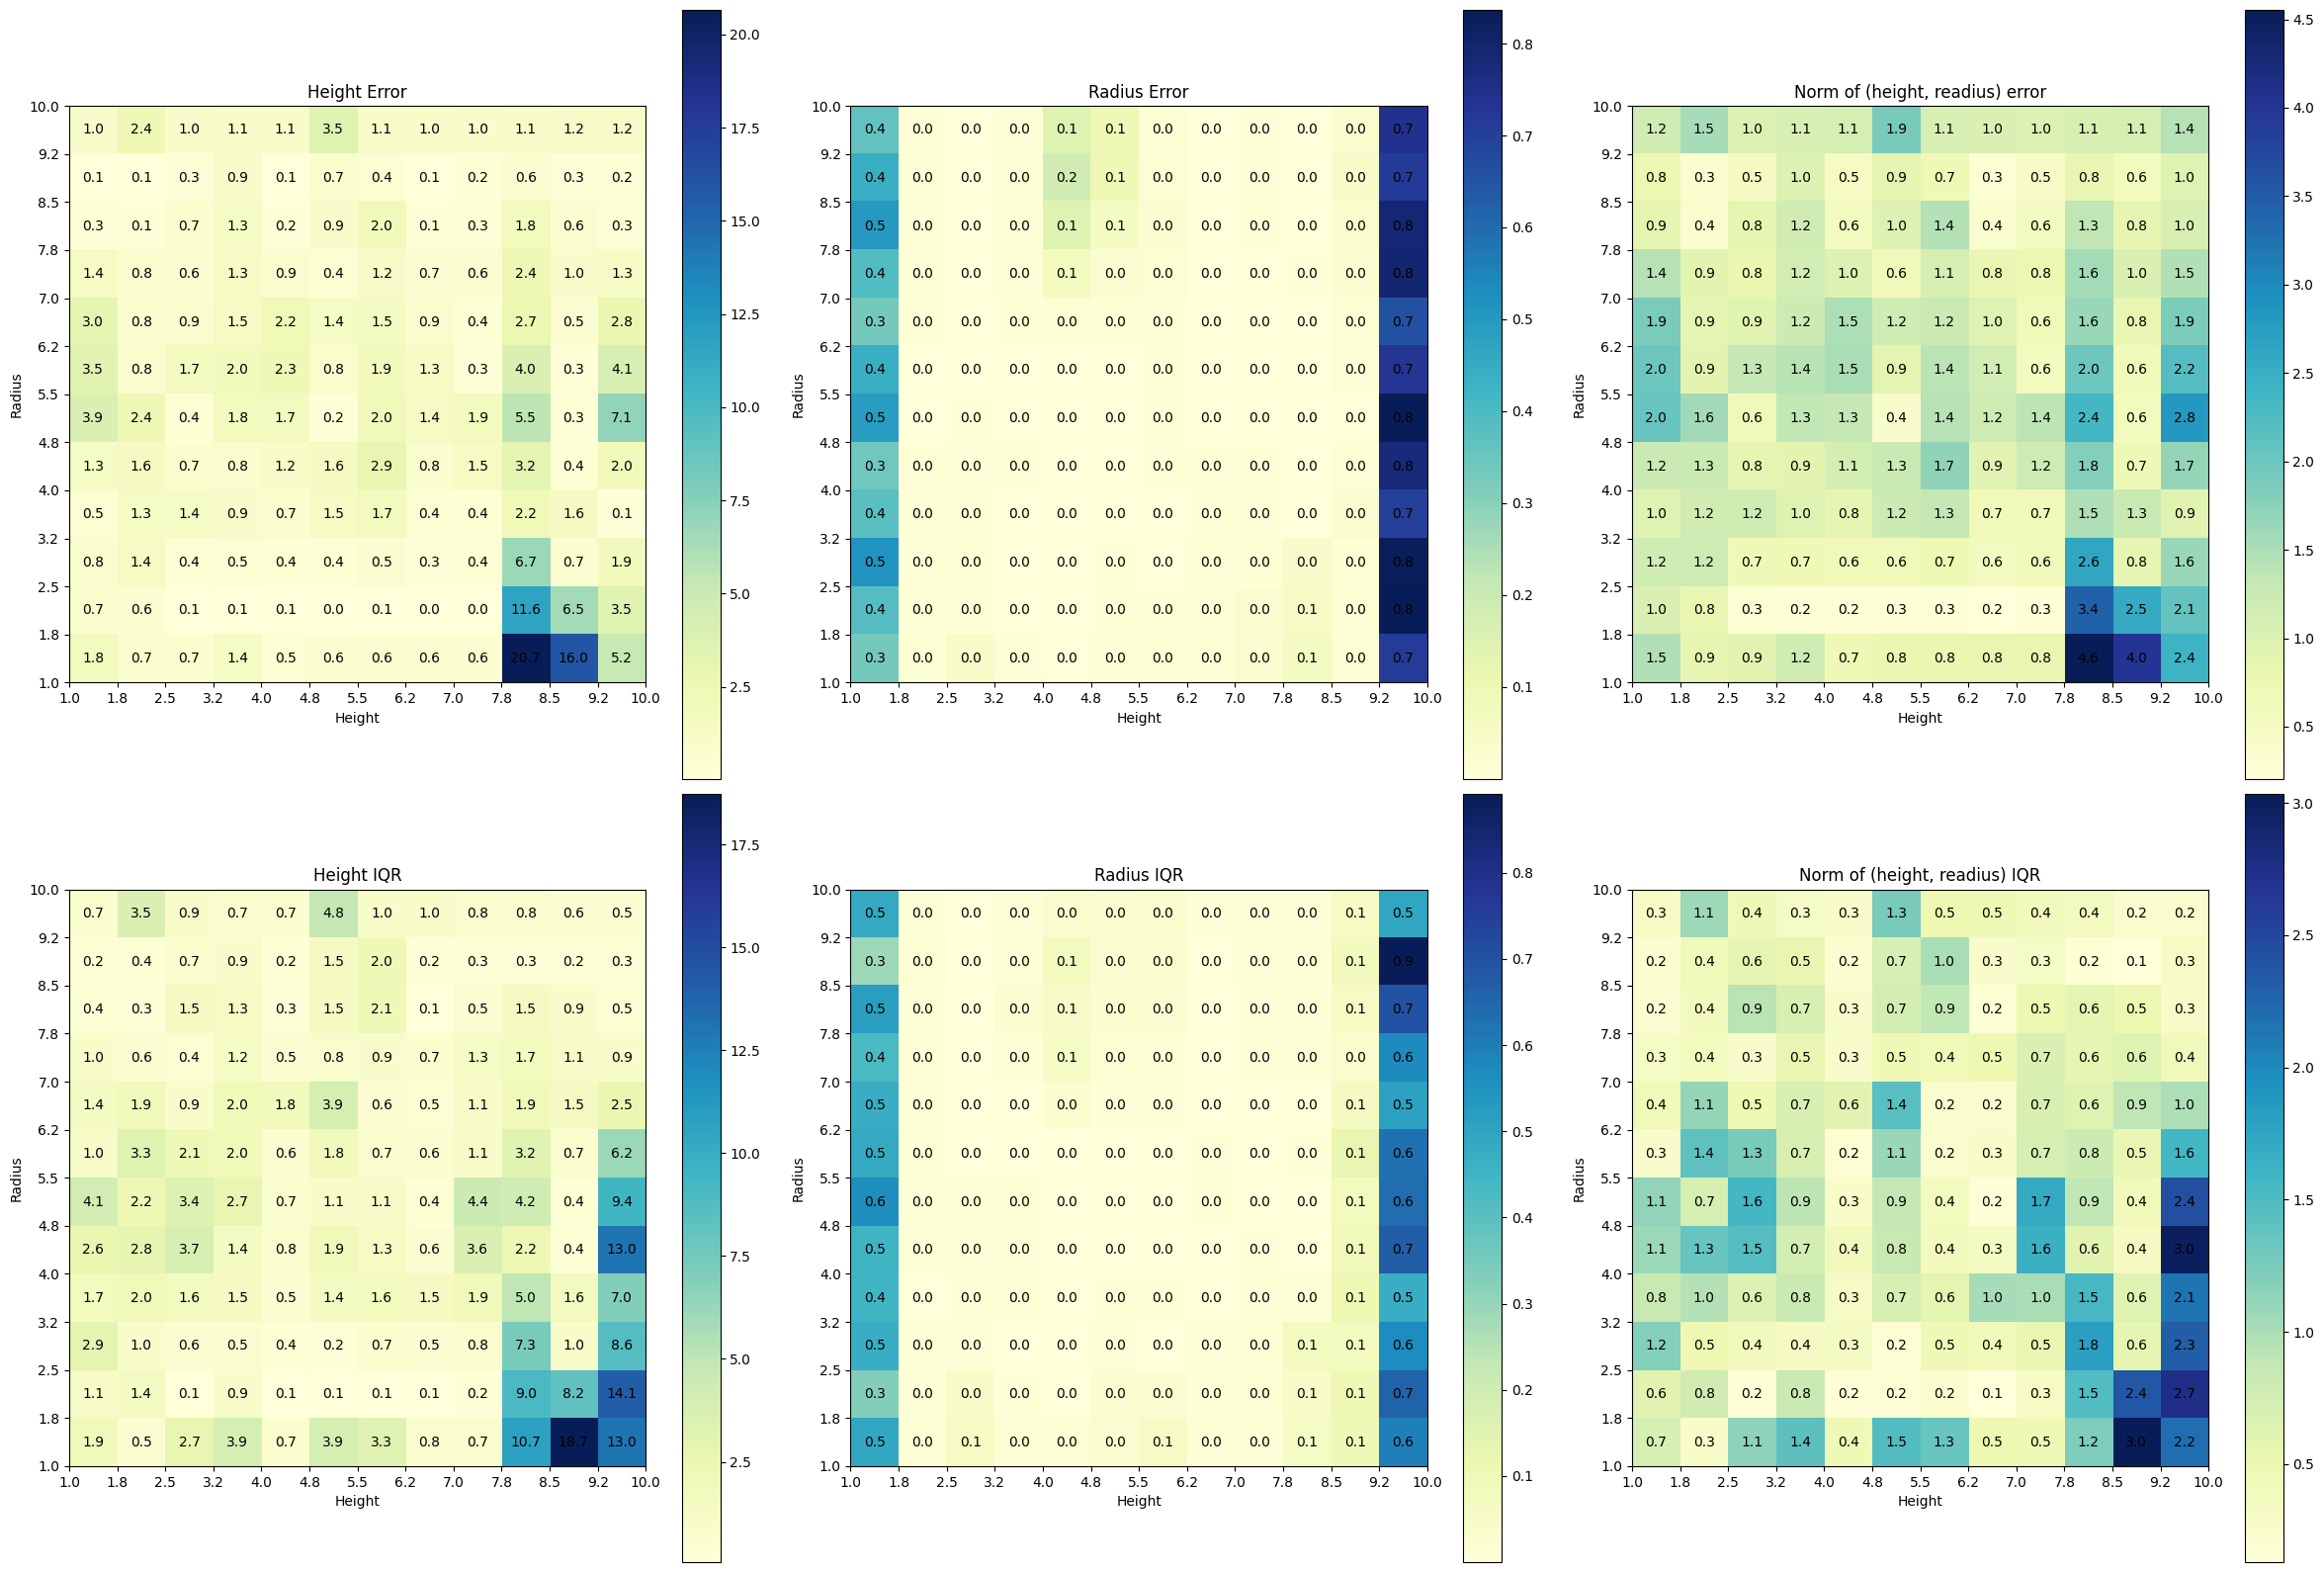

In [7]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')

plt.tight_layout()
plt.show()

In [9]:
intervals = [np.linspace(lw[0], up[0], pieces_cnt + 1), np.linspace(lw[1], up[1], pieces_cnt + 1)]
interval_runs = np.empty(shape=(pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i + 1], intervals[1][j + 1]]
        interval_up = [intervals[0][i + 1], intervals[1][j + 1]]
        test_control_vars = dataset_generator.get_control_vars(deterministic=False, dimensionality=roll_gen.get_p(),
                                                               size=test_data_size, lw=interval_lw, up=interval_up)
        test_rolls = roll_gen.generate_array_of_swiss_rolls(control_vars, noise_level=noise_level, min_num_points=figure_point_cnt)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means,
                                                       y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common),
                                np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [7.65811802 8.40039909], x_err = 0.8890322887975703
x_real = [1.75 1.75]
-----------
x_opt  = [5.35960008 7.26590183], x_err = 2.767715109666975
x_real = [1.75 1.75]
-----------
x_opt  = [2.77963956 5.79805863], x_err = 0.8443982985239763
x_real = [1.75 1.75]
-----------
x_opt  = [7.32785017 8.74931936], x_err = 4890.598127559164
x_real = [1.75 1.75]
-----------
x_opt  = [7.28525575 3.70869823], x_err = 5.850629977640359e-13
x_real = [1.75 1.75]
-----------
x_opt  = [2.41829965 8.74931936], x_err = 2070.8629512453795
x_real = [1.75 1.75]
-----------
x_opt  = [7.35968141 8.32447667], x_err = 0.15899135046607027
x_real = [1.75 1.75]
-----------
x_opt  = [2.41829965 8.74931936], x_err = 2902.041671101243
x_real = [1.75 1.75]
-----------
x_opt  = [7.57282203 8.74931936], x_err = 1956.5497295588202
x_real = [1.75 1.75]
-----------
x_opt  = [6.39723439 4.19198485], x_err = 0.011539647325185101
x_real = [1.75 1.75]
-----------
x_opt  = [7.74806891 1.99328916], x_err = 285

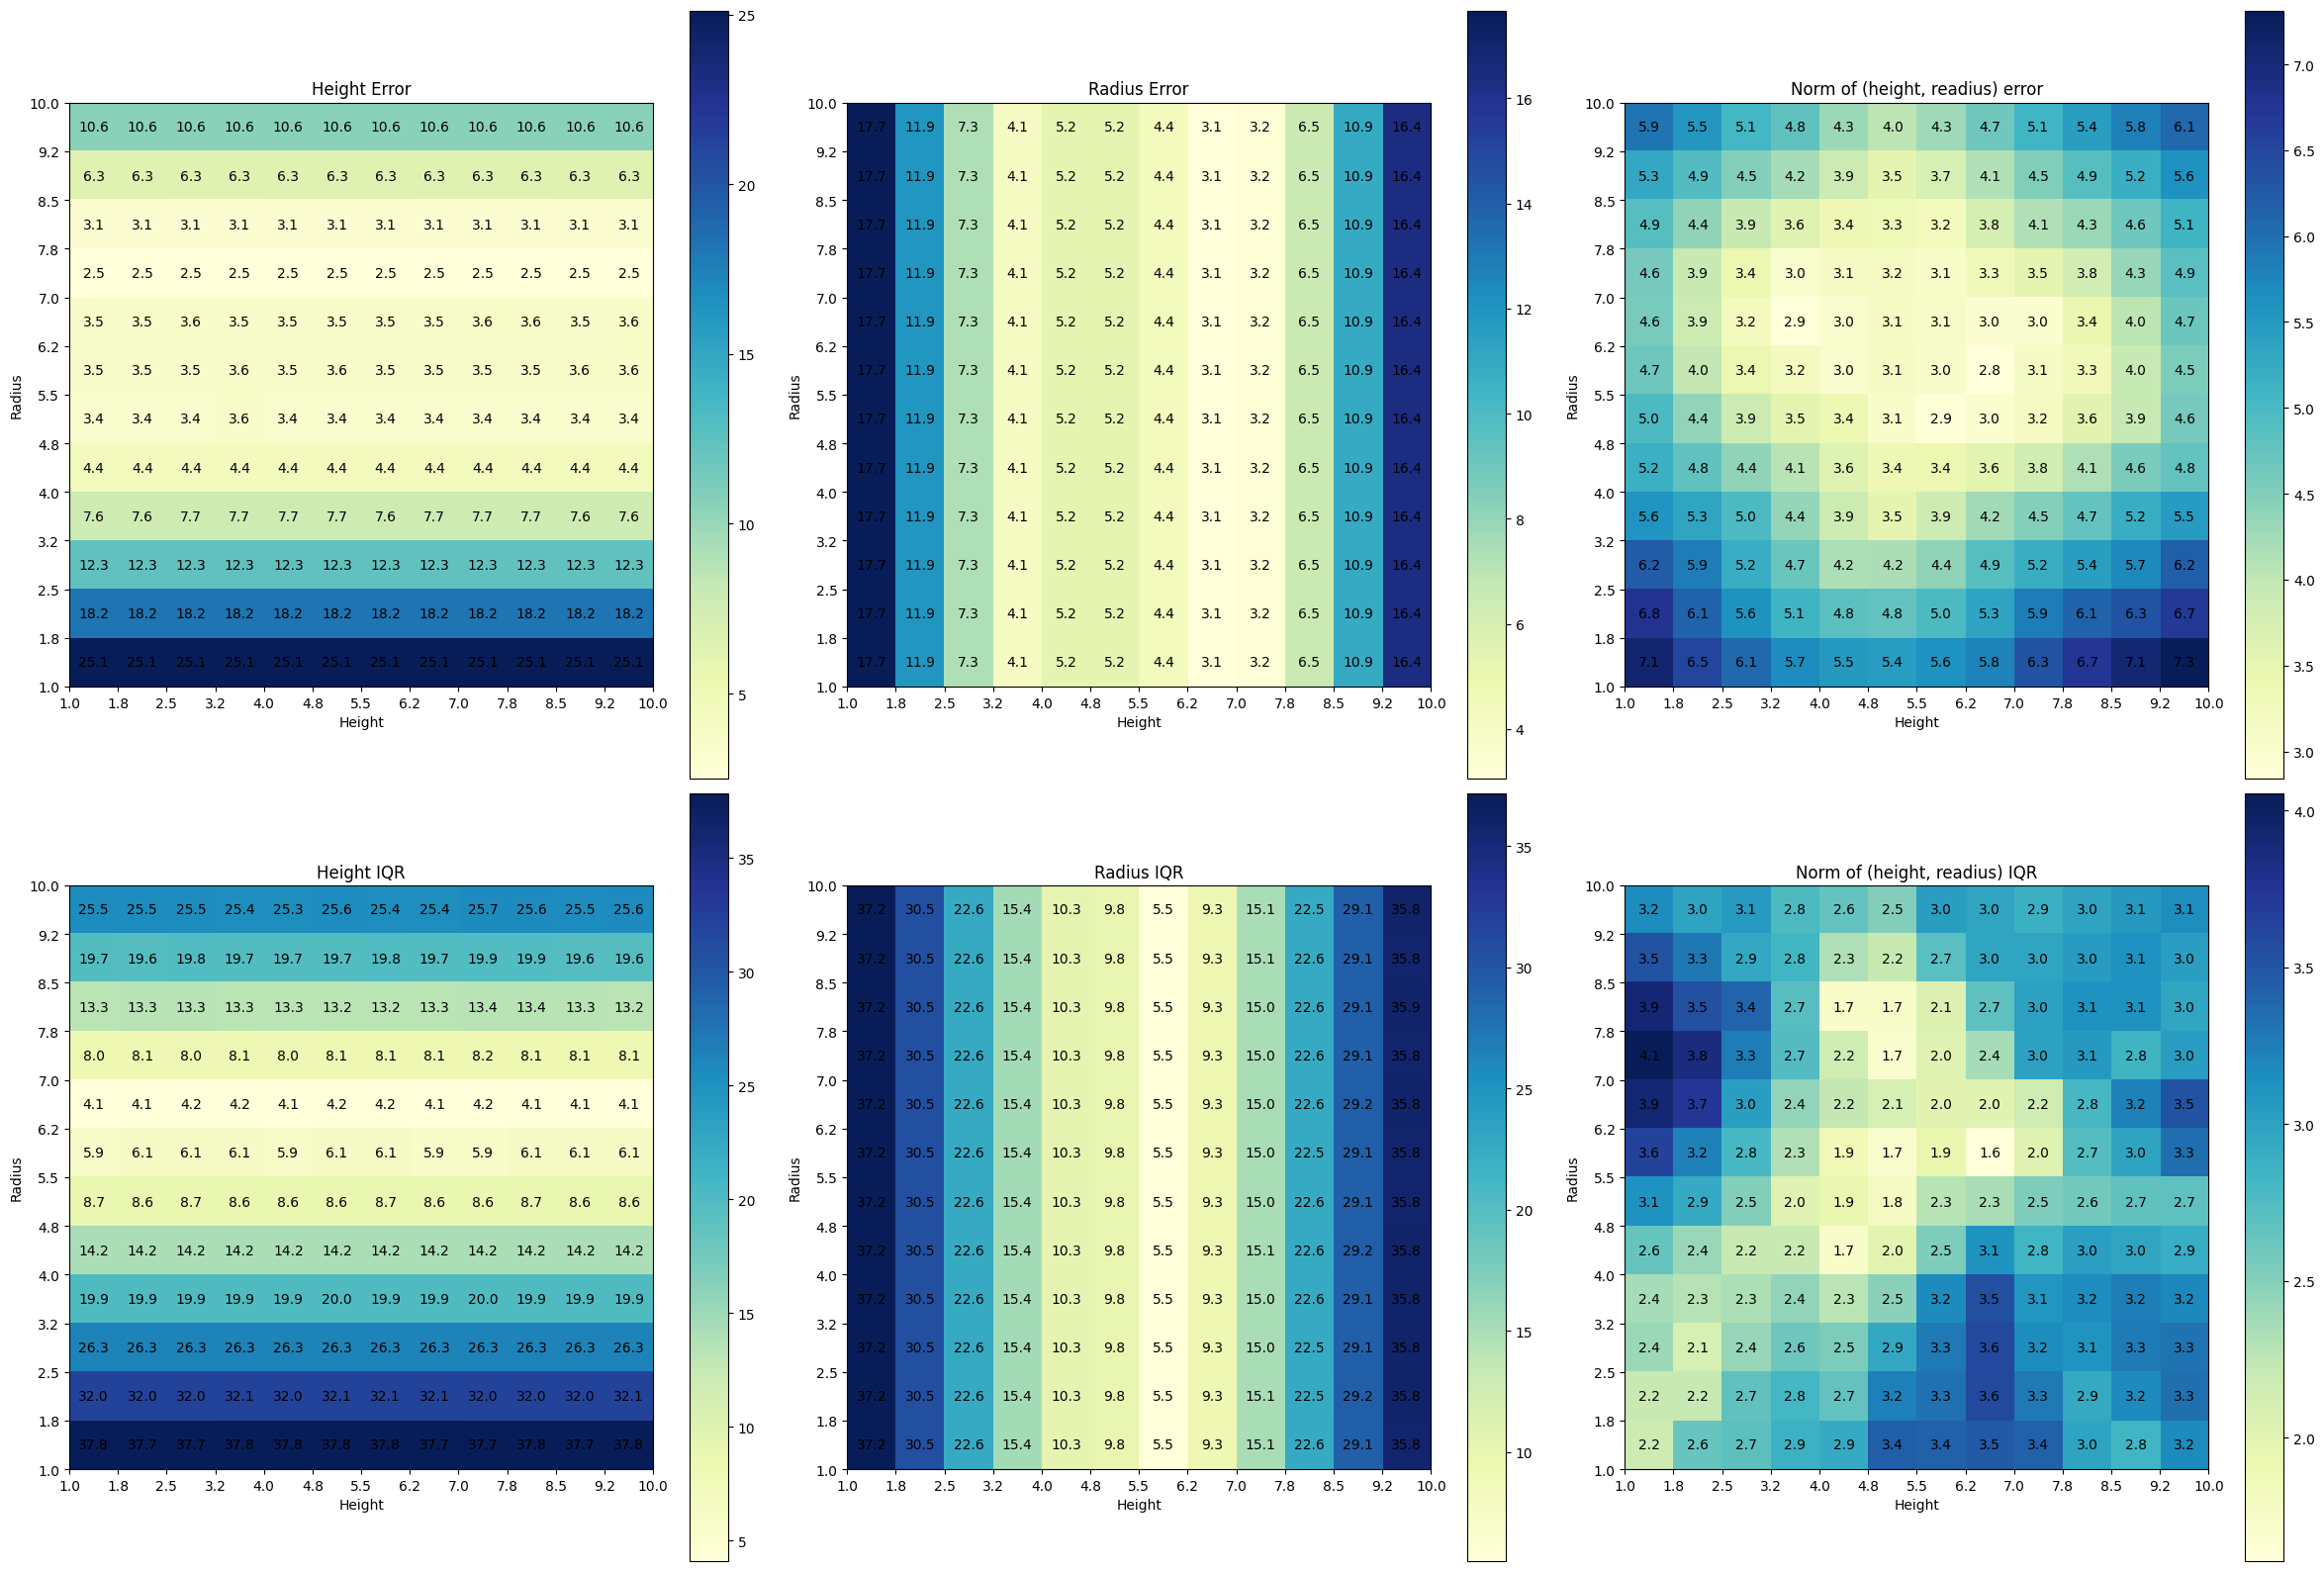

In [10]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt + 1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt + 1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')

plt.tight_layout()
plt.show()